In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Import Data

Read the data from our .csv file.

In [2]:
df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
gdp = pd.read_csv('gdp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
pop = pd.read_csv('population_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
tmp =  pd.read_csv('tmp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])

joined = df.join(gdp, on='DateTime', how='left', lsuffix = '', rsuffix = '_GDP', sort=False)

print(df.shape)
print(gdp.shape)

(87648, 40)
(10, 34)


In [6]:
joined = joined.join(pop, on='DateTime', how='left', lsuffix = '', rsuffix = '_POP', sort=False)
joined = joined.join(tmp, on='DateTime', how='left', lsuffix = '', rsuffix = '_TMP', sort=False)
joined = joined.replace(',','', regex=True)
joined_interpolate = joined.interpolate(method='ffill') # or method='index' works too
#pl = joined[['PL','PL_GDP','PL_POP', 'PL_TMP']]
print(joined)
print(joined_interpolate)

                           Date     Time      AT      BA      BE      BG  \
DateTime                                                                   
2006-01-01 00:00:00    1/1/2006     0:00  6297.0  1425.0  9829.0  4293.0   
2006-01-01 01:00:00    1/1/2006  1:00 AM  6005.0  1358.0  9447.0  4186.0   
2006-01-01 02:00:00    1/1/2006  2:00 AM  5743.0  1283.0  9062.0  4026.0   
2006-01-01 03:00:00    1/1/2006  3:00 AM  5397.0  1175.0  8589.0  3877.0   
2006-01-01 04:00:00    1/1/2006  4:00 AM  5213.0  1134.0  8247.0  3724.0   
...                         ...      ...     ...     ...     ...     ...   
2015-12-31 19:00:00  12/31/2015    19:00  8039.0  1959.0  9377.0  6353.0   
2015-12-31 20:00:00  12/31/2015    20:00  7521.0  1810.0  8908.0  5740.0   
2015-12-31 21:00:00  12/31/2015    21:00  7223.0  1680.0  8682.0  5273.0   
2015-12-31 22:00:00  12/31/2015    22:00  7424.0  1606.0  9045.0  5161.0   
2015-12-31 23:00:00  12/31/2015    23:00  7094.0  1537.0  9176.0  5105.0   

           

In [7]:
# get country-specific datasets

country_datasets = []
country_list = ['PL', 'DE']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([country, country_dataset])

for each in country_datasets:
    name = each[0]
    dataset = each[1]

print(dataset)

                          DE   DE_GDP      DE_POP      DE_POP  DE_TMP  DE_TMP
DateTime                                                                     
2006-01-01 00:00:00  47823.0  2994.70  81472226.0  81472226.0    -2.3    -2.3
2006-01-01 01:00:00  47823.0  2994.70  81472226.0  81472226.0    -2.3    -2.3
2006-01-01 02:00:00  43444.0  2994.70  81472226.0  81472226.0    -2.3    -2.3
2006-01-01 03:00:00  41432.0  2994.70  81472226.0  81472226.0    -2.3    -2.3
2006-01-01 04:00:00  40508.0  2994.70  81472226.0  81472226.0    -2.3    -2.3
...                      ...      ...         ...         ...     ...     ...
2015-12-31 19:00:00  52481.0  3357.59  81787411.0  81787411.0     2.6     2.6
2015-12-31 20:00:00  49056.0  3357.59  81787411.0  81787411.0     2.6     2.6
2015-12-31 21:00:00  47253.0  3357.59  81787411.0  81787411.0     2.6     2.6
2015-12-31 22:00:00  47057.0  3357.59  81787411.0  81787411.0     2.6     2.6
2015-12-31 23:00:00  45305.0  3357.59  81787411.0  81787411.0   

SVR(degree=20, kernel='poly')
24


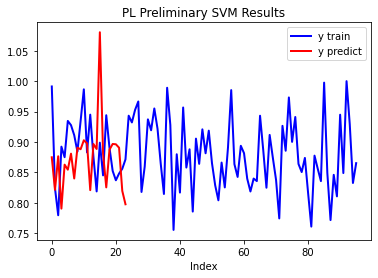

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

nonan = dataset.dropna()
#nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()
#print(nonan)
'''
# normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(nonan.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ['DE_GDP', 'DE_POP', 'DE_TMP'])
'''
# normalize
nonan = nonan / nonan.max(axis=0) # works

x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['DE'].values,test_size=0.2)



from sklearn.svm import SVR
svr = SVR(kernel="poly", degree=20, C=1.0, epsilon=0.1).fit(x_train, y_train)

#svr = SVR().fit(x_train, y_train)

print(svr)

y_train_predict = svr.predict(x_test)

print(y_train_predict.size)

#plt.plot( y_train_predict, lw=1, color="red", label="fitted")
plt.plot( y_train, lw=2, color="blue", label="y train")
plt.plot( y_train_predict, lw=2, color="red", label="y predict")
plt.legend()
plt.title("PL Preliminary SVM Results")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()